# Tuning curve, encoding, and decoding

In [20]:
#@title Run the following to initialize lab environment.

!pip install ipympl ipywidgets stg-net scipy -q

import matplotlib.pyplot as plt         # import matplotlib
from matplotlib.widgets import Slider
import numpy as np                      # import numpy
import scipy
import ipywidgets as widgets            # interactive display

# Colab setting for widget
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except ImportError:
    pass

# modeling library
from stg_net.neuron import LIF
from stg_net.input import Poisson_generator, Gaussian_generator, Current_injector
from stg_net.conn import Simulator
from stg_net.helper import plot_volt_trace

# setting for figures
fig_w, fig_h = 8, 6
my_fontsize = 18
my_params = {'axes.labelsize': my_fontsize,
          'axes.titlesize': my_fontsize,
          'figure.figsize': (fig_w, fig_h),
          'font.size': my_fontsize,
          'legend.fontsize': my_fontsize-4,
          'lines.markersize': 8.,
          'lines.linewidth': 2.,
          'xtick.labelsize': my_fontsize-2,
          'ytick.labelsize': my_fontsize-2}
plt.rcParams.update(my_params)
my_layout = widgets.Layout()

# Auto Reloading
%load_ext autoreload
%autoreload 2

# Widget interaction
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ValueError: Key backend: 'module://ipympl.backend_nbagg' is not a valid value for backend; supported values are ['gtk3agg', 'gtk3cairo', 'gtk4agg', 'gtk4cairo', 'macosx', 'nbagg', 'notebook', 'qtagg', 'qtcairo', 'qt5agg', 'qt5cairo', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wxagg', 'wxcairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template', 'inline']

## Tuning curves of neurons (40min)
Consider a situation in which N neurons are projecting onto a single neuron (target neuron). Each of the input neuron is tuned to a specific input e.g. orientation of a moving bar. When the input weights are carefully chosen we can make the target neuron sensitive to a small range of input orientations. Such tuning of inputs is a hallmark of early sensory representation in the neocortex. Furthermore, we can use this tuning property of the neurons to decode the input.

In this exercise you will first manually change the input weights to make a single neuron tuned to a range of inputs. After that we will use Hebbian plasticity to learn the weights.

<img src="https://github.com/weirdoglh/ComBioNetwork/blob/main/book/Lab2/sensory-encoding.PNG?raw=true" alt="Encoding network" width="1000"/>

GridspecLayout(children=(Text(value='location', disabled=True, layout=Layout(grid_area='widget001', width='200…

Output()

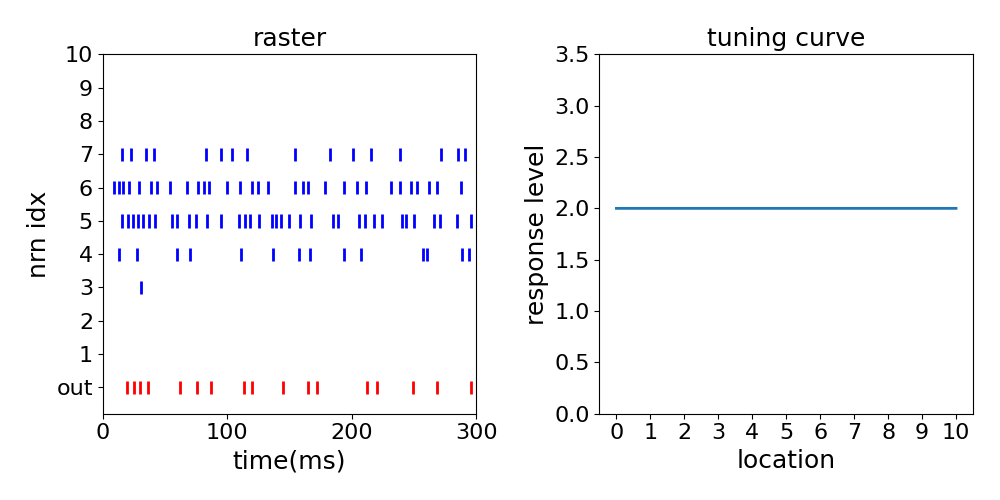

In [ ]:
#@title Run the following to manipulate tuning curve { vertical-output: true }
T, dt = 3e2, 0.1        # simulation period(ms), step size(ms)
N = 10              # number of neurons

tonic_neuron = {'tau_m':20., 'a':0., 'tau_w':30., 'b':3., 'V_reset':-55.}
adapting_neuron = {'tau_m':20., 'a':0., 'tau_w':100., 'b':0.5, 'V_reset':-55.}
initburst_neuron = {'tau_m':10., 'a':0., 'tau_w':100., 'b':1., 'V_reset':-50.}
bursting_neuron = {'tau_m':5., 'a':0., 'tau_w':100., 'b':1., 'V_reset':-46.}
irregular_neuron = {'tau_m':10., 'a':-0.01, 'tau_w':50., 'b':1.2, 'V_reset':-46.}
transient_neuron = {'tau_m':5., 'a':0.05, 'tau_w':100., 'b':0.7, 'V_reset':-60.}
delayed_neuron = {'tau_m':5., 'a':-0.1, 'tau_w':100., 'b':1., 'V_reset':-60.}

neuron_params = {'tonic_neuron': tonic_neuron, 'adapting_neuron': adapting_neuron,
                 'initburst_neuron': initburst_neuron, 'bursting_neuron': bursting_neuron,
                 'irregular_neuron': irregular_neuron, 'transient_neuron': transient_neuron,
                 'delayed_neuron': delayed_neuron, 'my_neuron': tonic_neuron}

# inputs
ms, xs = np.linspace(0., 1., 101), np.linspace(0.05-1e-5, 0.95-1e-5, N)
rins = [np.array([max(scipy.stats.norm(mean, 0.1).pdf([x, x-1, 1+x]))  for x in xs]) for mean in ms]

# weights
grid = widgets.GridspecLayout(2, N+2)
wsize = '200px'
for i, label in enumerate(['location','spread'] + ['J_o%d'%i for i in np.arange(1, N+1)]):
    grid[0, i] = widgets.Text(value=label, disabled=True, layout=widgets.Layout(width=wsize))
for i in np.arange(2, N+2):
    grid[1, i] = widgets.FloatSlider(value=0.2, min=0.0, max=0.4, step=0.01, layout=widgets.Layout(width=wsize))
grid[1, 0] = widgets.FloatSlider(value=5, min=0, max=10, step=0.1, layout=widgets.Layout(width=wsize))
grid[1, 1] = widgets.FloatSlider(value=1, min=0, max=2, step=0.1, layout=widgets.Layout(width=wsize))

con_bars = {}
con_bars['mean'] = grid[1, 0]
con_bars['std'] = grid[1, 1]
for i in np.arange(1, N+1):
    con_bars['J_o%d'%i] = grid[1, i+1]

# updating parameters
def update_tune(**con_dict):
    # simualtor
    h = Simulator(dt=dt)

    # network of neurons
    nrns = [LIF(sim=h) for _ in range(N)]
    for nrn in nrns:
        nrn.update(tonic_neuron)

    # input and weights
    cons = np.array(list(con_dict.values()), dtype=float)
    mean, std, ws = cons[0]/10, cons[1]/10, cons[2:]

    # background noise
    rdist = [max(scipy.stats.norm(mean, std).pdf([x, x-1, 1+x])) for x in xs]
    rs = np.array([0.5] + rdist)*1e2
    noises = [Poisson_generator(sim=h, rate=r*3, start=0, end=int(T/dt)) for r in rs]
    for noise, nrn in zip(noises, nrns):
        nrn.connect(noise, {'ctype':'Static', 'weight':1e0, 'delay':5})

    # recurrent connections
    tps = [['Static' for _ in range(N)] for _ in range(N)]
    con = np.zeros((N,N))
    con[0] = ws * 5
    dly = np.random.uniform(2., 5., (N,N))
    synspecs = [[{} for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            synspecs[i][j] = {'ctype':tps[i][j], 'weight':con[i,j], 'delay':dly[i,j]}
    h.connect(nrns, nrns, synspecs)

    # simulation
    h.run(T)

    # save weight
    ys = np.array([np.dot(ws, rin) for rin in rins])

    # visualize
    plt.clf()
    plt.subplot(1,2,1)
    plt.title('raster')
    for nrn, l in zip(nrns, range(N)):
        if l == 0:
            plt.eventplot(nrn.spikes['times'], colors='r', lineoffsets=l, linelengths=0.4, label='%.1fHz'%(len(nrn.spikes['times'])/T*1e3*2))
        else:
            plt.eventplot(nrn.spikes['times'], colors='b', lineoffsets=l, linelengths=0.4, label='%.1fHz'%(len(nrn.spikes['times'])/T*1e3*2))
    plt.xlabel('time(ms)')
    plt.yticks(list(np.arange(N+1)), ['out'] + list(np.arange(1, N+1)))
    plt.ylabel('nrn idx')
    plt.xlim([0., T])

    plt.subplot(1,2,2)
    plt.title('tuning curve')
    plt.plot(ms, ys)
    plt.xlabel('location')
    plt.xticks(list(np.arange(N+1)/10), list(np.arange(N+1)))
    plt.ylabel('response level')
    plt.ylim([0, 3.5])

    plt.tight_layout()

try:
    plt.figure(fig_tune)
    plt.clf()
except:
    ...
fig_tune, axes = plt.subplots(1,2,figsize=(10,5))
widget_tune = widgets.interactive_output(update_tune, con_bars);
display(grid, widget_tune);

## To do

Try to change the feed-forward synaptic weights to have an output neuron with arbitrary tuning curve.

<Figure size 1000x1500 with 0 Axes>

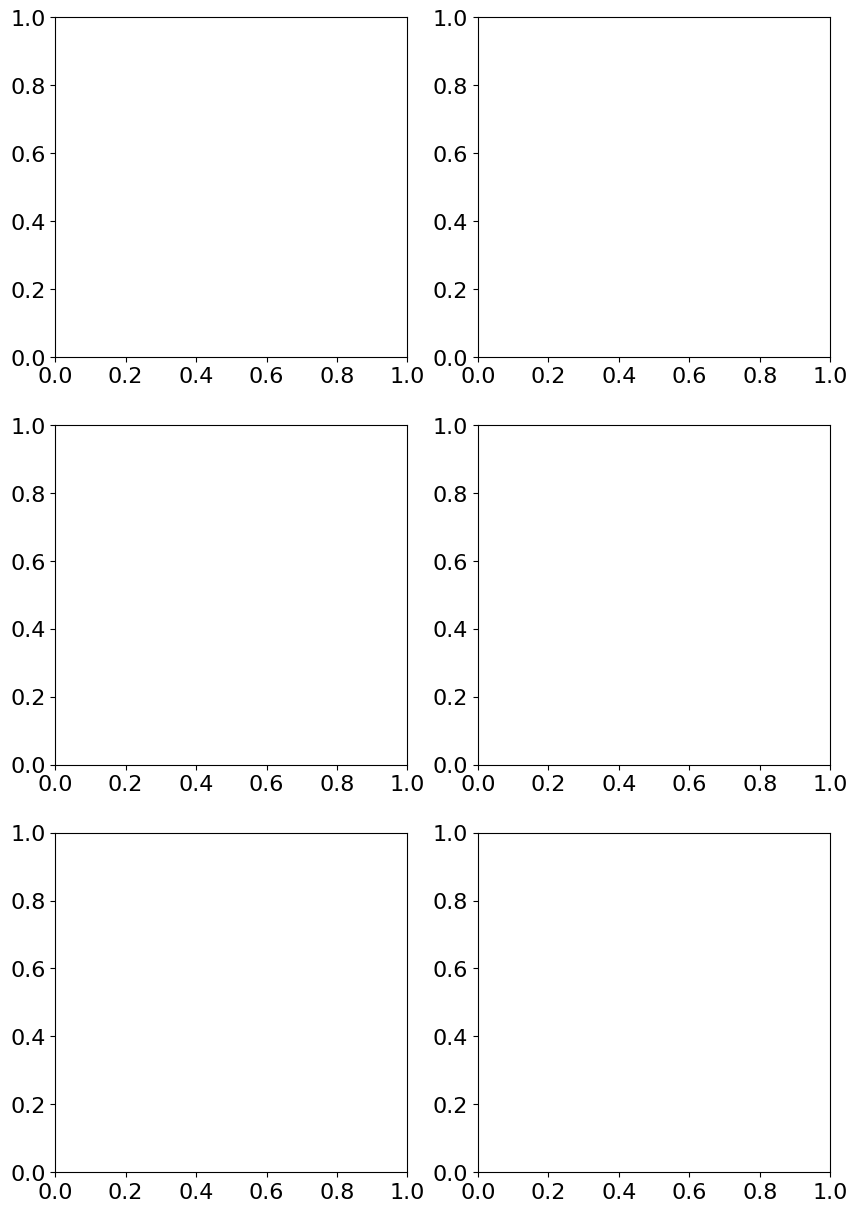

interactive(children=(FloatSlider(value=0.5, description='mean', max=1.0, step=0.01), FloatSlider(value=0.1, d…

In [21]:
#@title Run the following to start competitive learning, when output neuron spikes all synapses change plasticity according to their local activity.  { vertical-output: true }
T, dt = 3e2, 0.1        # simulation period(ms), step size(ms)

# output neurons
out_labels = ['a', 'b']
M = len(out_labels)     # number of cells
N = 10           # number of neurons

# inputs
std_low, std_high = 0.02, 0.2
ms, ss, xs = np.linspace(0., 1., 11), np.linspace(std_low, std_high, 11), np.linspace(0.05-1e-5, 0.95-1e-5, N)
rins = np.array([[[max(scipy.stats.norm(mean, std).pdf([x, x-1, 1+x])) for x in xs] for std in ss] for mean in ms])

# weights
ws = np.ones((M, N)) * 0.25

# outputs
ys = np.zeros((M, len(ms), len(ss)))

# recordings
samples = []
responses = []

# updating parameters
def update_comp(mean=0.5, std=0.1,  outIdx='a', plasticity=False):
    nIdx = out_labels.index(outIdx)
    # simualtor
    h = Simulator(dt=dt)

    # network of neurons
    nrns = [LIF(sim=h) for _ in range(M+N)]
    for nrn in nrns:
        nrn.update(tonic_neuron)

    # background noise
    rdist = [max(scipy.stats.norm(mean, std).pdf([x, x-1, 1+x])) for x in xs]
    rs = np.array([0.5]*M + rdist)*1e3/np.sum(rdist)
    noises = [Poisson_generator(sim=h, rate=r*3, start=0, end=int(T/dt)) for r in rs]
    for noise, nrn in zip(noises, nrns):
        nrn.connect(noise, {'ctype':'Static', 'weight':1e0, 'delay':5})

    # recurrent connections
    tps = [['Static' for _ in range(M+N)] for _ in range(M+N)]
    if plasticity:
        for i in np.arange(N):
            tps[nIdx][i+M] = 'Comp'
    con = np.zeros((M+N, M+N))
    global ws
    for i in range(M):
        con[i, M:] = ws[i]
    dly = np.random.uniform(2., 5., (M+N, M+N))
    synspecs = [[{} for _ in range(M+N)] for _ in range(M+N)]
    for i in range(M+N):
        for j in range(M+N):
            synspecs[i][j] = {'ctype':tps[i][j], 'weight':con[i,j], 'delay':dly[i,j]}
    cons = h.connect(nrns, nrns, synspecs)

    # simulation
    h.run(T)

    # save weight
    global samples
    global responses
    if plasticity:
        ws[nIdx] = np.array([cons[nIdx][i+M].weights[-1] for i in np.arange(0, N)])
        samples = []
        responses = []

    # update tuning curve
    global ys
    for k in range(M):
        for i in range(len(ms)):
            for j in range(len(ss)):
                ys[k, i, j] = np.dot(ws[k], rins[i,j])

    # collect samples
    if not plasticity:
        samples.append([mean, std])
        responses.append([len(nrns[i].spikes['times']) for i in range(M)])

    # visualize
    plt.clf()
    plt.subplot(3,2,1)
    plt.title('raster')
    for nrn, l in zip(nrns, range(M+N)):
        if l < M:
            plt.eventplot(nrn.spikes['times'], colors='r', lineoffsets=l, linelengths=0.4, label='%.1fHz'%(len(nrn.spikes['times'])/T*1e3*2))
        else:
            plt.eventplot(nrn.spikes['times'], colors='b', lineoffsets=l, linelengths=0.4, label='%.1fHz'%(len(nrn.spikes['times'])/T*1e3*2))
    plt.xlabel('time(ms)')
    plt.yticks(list(np.arange(M+N)), out_labels + list(np.arange(1, N+1)))
    plt.ylabel('nrn idx')
    plt.xlim([0., T])

    plt.subplot(3,2,2)
    plt.title('synaptic weights')
    if plasticity:
        weights = np.array([cons[nIdx][i+M].weights for i in np.arange(0, N)])
        plt.imshow(weights[:, np.arange(0, int(T/dt), 100)], extent=[0, T, 1, 10], origin='lower', aspect=30)
    else:
        plt.imshow(np.tile(ws[nIdx], (int(T/dt/100), 1)).T, extent=[0, T, 1, 10], origin='lower', aspect=30)
    plt.xlabel('time(ms)')
    plt.ylabel('syn Idx')
    plt.colorbar()

    plt.subplot(3,2,3)
    plt.title('tuning curve a')
    plt.imshow(ys[0], extent=[std_low, std_high, 0., 1.0], origin='lower', aspect=std_high - std_low)
    plt.xlabel('std')
    plt.ylabel('mean')
    plt.colorbar()

    plt.subplot(3,2,4)
    plt.title('tuning curve b')
    plt.imshow(ys[1], extent=[std_low, std_high, 0., 1.0], origin='lower', aspect=std_high - std_low)
    plt.xlabel('std')
    plt.ylabel('mean')
    plt.colorbar()

    plt.subplot(3,2,5)
    plt.title('input patterns')
    if len(samples) > 0:
        plt.scatter(np.array(samples)[:, 0], np.array(samples)[:, 1], c=range(len(samples)))
    plt.xlabel('mean')
    plt.ylabel('std')
    plt.xlim([0., 1.])
    plt.ylim([std_low, std_high])

    plt.subplot(3,2,6)
    plt.title('output responses')
    if len(responses) > 0:
        plt.scatter(np.array(responses)[:, 0], np.array(responses)[:, 1], c=range(len(responses)))
    plt.xlabel('a(spikes)')
    plt.ylabel('b(spikes)')

    plt.tight_layout()

try:
    plt.figure(fig_comp)
    plt.clf()
except:
    ...
fig_comp, axes = plt.subplots(3,2,figsize=(10,15))
widgets.interact(update_comp, mean=(0., 1.0, 0.01), std=(std_low, std_high, 0.02), outIdx=out_labels, plasticity=[True, False]);

## To do

Instead of mannually setting the weights, plastic synapses are able to capture the input signal. Now you have two neurons a and b, train them to different tuning curves (plasticity on). Then turn off the plasticity and sample their collective respones to different stimuli.(last row in figure above)

## Think

* Are two neurons sufficient for decoding the mean and std of input pattern? If not, how many neurons are needed?
* How would you decode the input from the firing rates of a and b?
* For decoding mean and std, which is better for the choice of two tuning cruves: overlapping or non-overlapping? wider or narrower? single-peaked or multi-peaked? (What are the trade-offs?)